## Neural colaborative filtering(NCF)

논문구현 github: https://github.com/hexiangnan/neural_collaborative_filtering

* 환경 설정
    * Keras version: '1.0.7'
    * Theano version: '0.8.0'


* NeuMF.py 실행

    `python NeuMF.py --dataset ml-1m --epochs 20 --batch_size 256 --num_factors 8 --layers [64,32,16,8] --reg_mf 0 --reg_layers [0,0,0,0] --num_neg 4 --lr 0.001 --learner adam --verbose 1 --out 1`




***

`NeuMF.py`  
    
* ncf 모델 구현되어있음. without pre-training / with pre-training 두가지로 미리 학습된 weight 를 사용할 수도 있음.

`Dataset.py`

* 데이터셋을 불러오는 클래스 정의되어 있음

`evaluate.py`

* Hit_Ratio, NDCG 를 구하는 함수

`GMF.py`

* GMF가 구현되어있다. pre-train된 weights를 불러올 때 사용된다.

`MLP.py`

* MLP가 구현되어있다. pre-train된 weights를 불러올 때 사용된다.
***

## GMF.py

* $\textbf{p}_u =\textbf{P}^{T}\textbf{v}^{u}_{U}$ :  user latnet vector(임베딩 행렬과 one hot encoding vector를 곱한 것)

* $\textbf{q}_{i} = \textbf{Q}^{T}\textbf{v}^{i}_{I}$ : item latent vector(임베딩 행렬과 one hot encoding vector를 곱한 것)


* $\phi_{1} (\textbf{p}_{u}, \textbf{q}_{i}) = \textbf{p}_{u} ⊙ \textbf{q}_{i}$ : user latent vector와 item latent vector의 element wise product

* ⊙ : element wise product

* $\hat{y}_{ui} = a_{out}(\textbf{h}^{T}(\textbf{p}_{u} ⊙ \textbf{q}_{i}))$ : 위의 값을 weight, sigmoid function 적용한 것 

* $\textbf{h}$ : output layer 의 weight

* $a_{out}$ : sigmoid 함수

* $\textbf{h}$ 가 모두 동일하게 1이라면 MF가 되는 것임 MF는 GMF의 특정한 경우이다. 

* $a_{out}$ 가 비선형 함수라면 결과도 비선형이 된다.

In [ ]:
def get_model(num_users, num_items, latent_dim, regs=[0,0]):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                  init = init_normal, W_regularizer = l2(regs[0]), input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                  init = init_normal, W_regularizer = l2(regs[1]), input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = merge([user_latent, item_latent], mode = 'mul')
    
    # Final prediction layer
    #prediction = Lambda(lambda x: K.sigmoid(K.sum(x)), output_shape=(1,))(predict_vector)
    prediction = Dense(1, activation='sigmoid', init='lecun_uniform', name = 'prediction')(predict_vector)
    
    model = Model(input=[user_input, item_input], 
                output=prediction)

    return model

## MLP.py

* $\textbf{p}_u$ 와 $\textbf{p}_i$의 관계성을 학습하기 위해 mlp사용

* $\textbf{z}_{1} = \phi_{1}(\textbf{p}_{u}, \textbf{q}_{i}) = {\textbf{p}_{u} \choose \textbf{q}_{i}}$ : concat(user, item)

* $\phi_{2}(\textbf{z}_1) = a_{2}(\textbf{W}_{2}^{T} \textbf{z}_1 + \textbf{b}_2), ...$ : wx+b 형태의 weight와 bias 선형결합

* $\hat{y}_{ui} = \sigma(\textbf{h}^{T}\phi_{L}(\textbf{z}_{L-1}))$ : 마지막 layer weight 적용 후, 활성화 함수 

* 본 논문에서는 sigmoid, tanh 보다 ReLU가 성능이 더 좋았다고 함 

* ReLU 사용으로 비선형성가진다.

* 레이어의 노드수를 점점 줄여나가며 구성해서 추상적인 피쳐를 학습할 수 있다.

* dense(64) -> dense(32) -> dense(16) -> dense(8)

In [ ]:
def get_model(num_users, num_items, layers = [20,10], reg_layers=[0,0]):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) #Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = layers[0]/2, name = 'user_embedding',
                                  init = init_normal, W_regularizer = l2(reg_layers[0]), input_length=1)
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = layers[0]/2, name = 'item_embedding',
                                  init = init_normal, W_regularizer = l2(reg_layers[0]), input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    # The 0-th layer is the concatenation of embedding layers
    vector = merge([user_latent, item_latent], mode = 'concat')
    
    # MLP layers
    for idx in xrange(1, num_layer):
        layer = Dense(layers[idx], W_regularizer= l2(reg_layers[idx]), activation='relu', name = 'layer%d' %idx)
        vector = layer(vector)
        
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', init='lecun_uniform', name = 'prediction')(vector)
    
    model = Model(input=[user_input, item_input], 
                  output=prediction)
    
    return model

## NeuMF.py

$\phi^{GMF} = \textbf{p}_{u}^{G} ⊙ \textbf{q}_{i}^{G}$ 

$\phi^{MLP} = a_{L}(\textbf{W}_{L}^{T}(a_{L-1}(...a_{2}(\textbf{W}_{2}^{T} {\textbf{p}_{u}^{M} \choose \textbf{q}_{i}^{M}} + \textbf{b}_{2})...)) +\textbf{b}_L)$

$\hat{y}_{ui} = \sigma(\textbf{h}^{T} {\phi^{GMF} \choose \phi^{MLP}})$

* GMF와 MLP의 유저와 아이템 임베딩을 공유하는 것은 fused model의 성능을 저하할 수 있음

* 따로 임베딩 학습하고 마지막 히든 레이어에서 concat한다.

* MLP의 활성화 함수는 ReLU를 사용

* 선형성을 가지는 GMF와(sigmoid) 비선형성을 가지는 MLP(ReLU)를 합하여 user와 item의 latent 구조를 모델링한다. 


***

* INPUT

    * user id,  item id
    

* OUTPUT

    * predicted implicit rating
    

* GMF
    * embedding dim = 8
    
    * user embedding * item embedding , element wise product 를 한다.
    
    * sigmoid
    
    
* MLP
    * embedding dim = 8
    
    * concat(user embedding, item embedding)
    
    * dense(64) -> dense(32) -> dense(16) -> dense(8)
    
    * ReLU

<left><img src="https://user-images.githubusercontent.com/43728746/76158529-0231f200-615a-11ea-9937-ae3afac82c46.png" width="700" height="700"></left>

In [ ]:
# 모델 구성 함수
def get_model(num_users, num_items, mf_dim=10, layers=[10], reg_layers=[0], reg_mf=0):
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) #Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
    # GMF Embedding layer
    # 유저 임베딩 input dim = 유저의 nunique, output dim = 8 
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = mf_dim, name = 'mf_embedding_user',
                                  init = init_normal, W_regularizer = l2(reg_mf), input_length=1)
    # 아이템 임베딩 input dim = 아이템의 nunique, output dim = 8
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = mf_dim, name = 'mf_embedding_item',
                                  init = init_normal, W_regularizer = l2(reg_mf), input_length=1)   
    # MLP Embedding layer
    # 유저 임베딩 input dim = 유저의 nunique, output dim = 8 
    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = layers[0]/2, name = "mlp_embedding_user",
                                  init = init_normal, W_regularizer = l2(reg_layers[0]), input_length=1)
    # 아이템 임베딩 input dim = 아이템의 nunique, output dim = 8
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = layers[0]/2, name = 'mlp_embedding_item',
                                  init = init_normal, W_regularizer = l2(reg_layers[0]), input_length=1)   
    
    # GMF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input)) # 유저 임베딩 flattem 크기가 8인 임베딩 형성
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input)) # 아이템 임베딩 flatten
    mf_vector = merge([mf_user_latent, mf_item_latent], mode = 'mul') # 유저임베딩과 아이템 임베딩 element-wise multiply 

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input)) # 유저 임베딩 flattem
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input)) # 아이템 임베딩 flatten
    mlp_vector = merge([mlp_user_latent, mlp_item_latent], mode = 'concat') # 유저임베딩과 아이템 임베딩 concat
    for idx in xrange(1, num_layer): # layers [64,32,16,8]
        layer = Dense(layers[idx], W_regularizer= l2(reg_layers[idx]), activation='relu', name="layer%d" %idx)
        mlp_vector = layer(mlp_vector) # concat된 유저,아이템 임베딩이 64 -> 32 -> 16 -> 8 개의 노드를 가지는 FC 레이어를 통과한다.

    # Concatenate MF and MLP parts
    predict_vector = merge([mf_vector, mlp_vector], mode = 'concat') # GMF, MLP concat 
    
    # Final prediction layer
    # sigmoid 를 활성화 함수로 최종 prediction 생성
    prediction = Dense(1, activation='sigmoid', init='lecun_uniform', name = "prediction")(predict_vector) 
    
    model = Model(input=[user_input, item_input], 
                  output=prediction)
    
    return model

## Pre-training

* NeuMF의 loss function의 non-convecxity때문에 locally-optimal 하게 된다. 

* GMP와 MLP의 weight를 랜덤초기화한다음 수렴할 때까지 학습하고, 각각의 학습된 weight를 NeuMF의 초기 파라미터로 사용.

* $\textbf{h} <-  {\alpha \textbf{h}^{GMF} \choose (1-\alpha) \textbf{h}^{MLP}}$ 

* h는 마지막 output layer의 weight 의미

* $\alpha$ 는 hyperparameter임. 저자는 0.5를 사용

* GMP와 MLP 학습할 때는 더 빠른 수렴과 학습률 조정의 어려움을 피하기 위해 Adam을 사용하고

* NeuMF 학습할때는 pre-train된 가중치로 초기화하고 모멘텀을 저장하지 않기 때문에 vanilla SGD를 사용

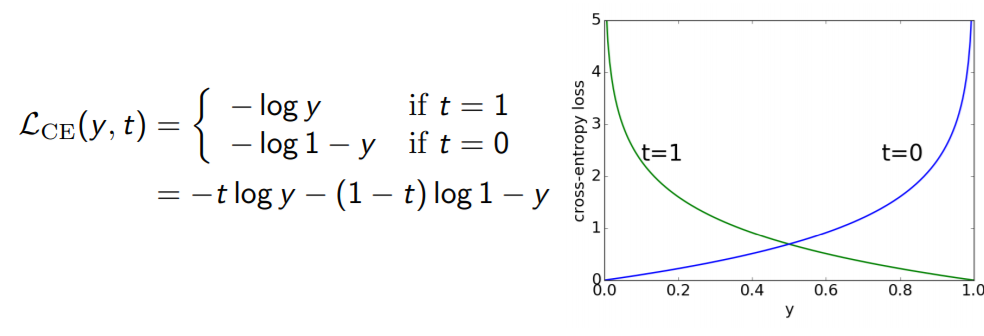

In [2]:
# pre-trained model
def load_pretrain_model(model, gmf_model, mlp_model, num_layers):
    # MF embeddings
    gmf_user_embeddings = gmf_model.get_layer('user_embedding').get_weights()
    gmf_item_embeddings = gmf_model.get_layer('item_embedding').get_weights()
    model.get_layer('mf_embedding_user').set_weights(gmf_user_embeddings)
    model.get_layer('mf_embedding_item').set_weights(gmf_item_embeddings)
    
    # MLP embeddings
    mlp_user_embeddings = mlp_model.get_layer('user_embedding').get_weights()
    mlp_item_embeddings = mlp_model.get_layer('item_embedding').get_weights()
    model.get_layer('mlp_embedding_user').set_weights(mlp_user_embeddings)
    model.get_layer('mlp_embedding_item').set_weights(mlp_item_embeddings)
    
    # MLP layers
    for i in xrange(1, num_layers):
        mlp_layer_weights = mlp_model.get_layer('layer%d' %i).get_weights()
        model.get_layer('layer%d' %i).set_weights(mlp_layer_weights)
        
    # Prediction weights
    gmf_prediction = gmf_model.get_layer('prediction').get_weights()
    mlp_prediction = mlp_model.get_layer('prediction').get_weights()
    new_weights = np.concatenate((gmf_prediction[0], mlp_prediction[0]), axis=0)
    new_b = gmf_prediction[1] + mlp_prediction[1]
    model.get_layer('prediction').set_weights([0.5*new_weights, 0.5*new_b])    
    return model

## Negative sampling

positive sample 한개당 4개의 negative sample 추출해서 positive, negative 둘다 균형적으로 학습할 수 있도록 함

참고: https://developers.google.com/machine-learning/recommendation/dnn/training

In [ ]:
# 네거티브 샘플링 함수
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [],[],[]
    num_users = train.shape[0]
    
    for (u, i) in train.keys():
        # positive instance 연관이 있는 샘플(시청한 샘플)
        user_input.append(u)
        item_input.append(i)
        labels.append(1) 
        # negative instances 연관이 없는 샘플(시청하지 않은 샘플) 4개를 뽑는다. 
        for t in xrange(num_negatives):
            j = np.random.randint(num_items)
            while train.has_key((u, j)):
                j = np.random.randint(num_items)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels # train sample 하나당 4개의 negative sample을 뽑는다.

## Build model

In [ ]:
# Build model
# 옵티마이저는 adam을 사용
model = get_model(num_users, num_items, mf_dim, layers, reg_layers, reg_mf)
if learner.lower() == "adagrad": 
    model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy')
elif learner.lower() == "rmsprop":
    model.compile(optimizer=RMSprop(lr=learning_rate), loss='binary_crossentropy')
elif learner.lower() == "adam":
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
else:
    model.compile(optimizer=SGD(lr=learning_rate), loss='binary_crossentropy') # 논문 저자는 adam 사용

## Training model

In [ ]:
# Training model 
# 정해진 에폭 만큼 모델 학습
for epoch in xrange(num_epochs):
    t1 = time()
    # 네거티브 샘플링을 통해 학습 데이터 생성 
    user_input, item_input, labels = get_train_instances(train, num_negatives) 

    # 모델 학습 
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                     np.array(labels), # labels 
                     batch_size=batch_size, nb_epoch=1, verbose=0, shuffle=True) 
    t2 = time()

    # Evaluation 
    if epoch %verbose == 0:
        (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
        hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['loss'][0]
        print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, loss = %.4f [%.1f s]' 
              % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
        if hr > best_hr:
            best_hr, best_ndcg, best_iter = hr, ndcg, epoch
            if args.out > 0:
                model.save_weights(model_out_file, overwrite=True)

print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))
if args.out > 0:
    print("The best NeuMF model is saved to %s" %(model_out_file))

## Dataset.py 
데이터셋 불러오는 클래스가 정의되어있음

ml-1m 데이터셋과 pinterest 데이터셋 두가지 중에 선택해서 불러올 수 있다.

In [ ]:
class Dataset(object):
    '''
    classdocs
    '''

    def __init__(self, path):
        '''
        Constructor
        '''
        self.trainMatrix = self.load_rating_file_as_matrix(path + ".train.rating")
        self.testRatings = self.load_rating_file_as_list(path + ".test.rating")
        self.testNegatives = self.load_negative_file(path + ".test.negative")
        assert len(self.testRatings) == len(self.testNegatives)
        
        self.num_users, self.num_items = self.trainMatrix.shape
        
    def load_rating_file_as_list(self, filename):
        ratingList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList
    
    def load_negative_file(self, filename):
        negativeList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                negatives = []
                for x in arr[1: ]:
                    negatives.append(int(x))
                negativeList.append(negatives)
                line = f.readline()
        return negativeList
    
    def load_rating_file_as_matrix(self, filename):
        '''
        Read .rating file and Return dok matrix.
        The first line of .rating file is: num_users\t num_items
        '''
        # Get number of users and items
        num_users, num_items = 0, 0
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
        # Construct matrix
        mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mat[user, item] = 1.0
                line = f.readline()    
        return mat

## evaluate.py
평가함수 클래스가 구현되어있음

top-K recommendation에서 `Hit_Ratio`, `NDCG` 를 구하는 함수, k=10

In [ ]:
def evaluate_model(model, testRatings, testNegatives, K, num_thread):
    
    hits, ndcgs = [],[]
    if(num_thread > 1): # Multi-thread
        pool = multiprocessing.Pool(processes=num_thread)
        res = pool.map(eval_one_rating, range(len(_testRatings)))
        pool.close()
        pool.join()
        hits = [r[0] for r in res]
        ndcgs = [r[1] for r in res]
        return (hits, ndcgs)
    # Single thread
    for idx in xrange(len(_testRatings)):
        (hr,ndcg) = eval_one_rating(idx)
        hits.append(hr)
        ndcgs.append(ndcg)      
    return (hits, ndcgs)

def eval_one_rating(idx):
    rating = _testRatings[idx]
    items = _testNegatives[idx]
    u = rating[0]
    gtItem = rating[1]
    items.append(gtItem)
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), u, dtype = 'int32')
    predictions = _model.predict([users, np.array(items)], 
                                 batch_size=100, verbose=0)
    for i in xrange(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    items.pop()
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(_K, map_item_score, key=map_item_score.get)
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    return (hr, ndcg)

def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in xrange(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

참고자료

https://leehyejin91.github.io/post-ncf/

https://dnddnjs.github.io/recomm/2019/08/15/neural_collaborative_filtering/

https://hwa-a-nui.tistory.com/23